In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# Get constants
with open("params_train.json", 'r') as file:
    params = json.load(file)

agent_name      = params['training']['AGENT_NAME']
model_name      = params['training']['MODEL_NAME']
training_rounds = params['training']['TRAINING_ROUNDS']

alpha  = params['Q-update']['ALPHA']
gamma  = params['Q-update']['GAMMA']
mode   = params['Q-update']['MODE']
n_step = params['Q-update']['N']

print(f"Trained 'agent_{agent_name}_{model_name}' for {training_rounds} rounds.")
print(f"Performed Q-update in {n_step}-step {mode} mode.  (alpha = {alpha}, gamma = {gamma})")

Trained 'agent_h2b_test_mode_3_&_dumb_map' for 1000 rounds.
Performed Q-update in 5-step SARSA mode.  (alpha = 0.1, gamma = 1)


In [3]:
# All possible features
all_direction_features = np.array(
    [
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 0, 2],
        [0, 0, 1, 2],
        [0, 1, 1, 2],
        [1, 1, 1, 2],
        [0, 0, 2, 2],
        [0, 1, 2, 2],
        [1, 1, 2, 2],
        [0, 2, 2, 2],
        [1, 2, 2, 2],
        [2, 2, 2, 2],   
    ]
)
all_own_spot_features  = np.array([0, 1, 2])
all_mode_features      = np.array([0, 1, 2])  

### Evaluating the trained model

In [4]:
trained_model = np.load(f"model_{agent_name}_{model_name}.pt", allow_pickle = True)
Sa_counter    = np.load("state_action_counter.npy")
policy        = np.argmax(trained_model, axis = -1)

In [5]:
def look_up_q_tensor(f5, f6):
    print(f"Q-Tensor for case (f5 = {f5}, f6 = {f6}):")
    print(f"state  direction features   policy  trained model  {'':20}number of encounters")
    for i in range(len(all_direction_features)):
        line = f"{i:2}{'':2}{all_direction_features[i]} {[f5, f6]}{'':2}{policy[i, f5, f6]}{'':2}["
        for Q_value in trained_model[i, f5, f6]:
            line += f"{Q_value:-7.3f}"
        line += f"]  {np.sum(Sa_counter[i, f5, f6]):5} ["
        for count in Sa_counter[i, f5, f6]:
            line += f" {count:5}"
        line += f"]"
        print(line)

In [6]:
look_up_q_tensor(1, 1)

Q-Tensor for case (f5 = 1, f6 = 1):
state  direction features   policy  trained model                      number of encounters
 0  [0 0 0 0] [1, 1]  5  [ -0.067  0.024 -0.195  0.011 -0.068  0.446]     21 [     2     2     2     4     4     7]
 1  [0 0 0 1] [1, 1]  3  [ -0.529 -0.848 -0.249  2.685 -0.116 -0.557]    109 [    12     7    15    45    10    20]
 2  [0 0 1 1] [1, 1]  3  [ -0.114  0.000  0.000  0.275  0.023  0.000]      3 [     1     0     0     1     1     0]
 3  [0 1 1 1] [1, 1]  5  [  0.000  0.000  0.000  0.000 -0.111  0.048]      2 [     0     0     0     0     1     1]
 4  [1 1 1 1] [1, 1]  0  [  0.000  0.000  0.000  0.000  0.000  0.000]      0 [     0     0     0     0     0     0]
 5  [0 0 0 2] [1, 1]  4  [  3.814  3.819  3.850  4.885  5.501  3.435]  30343 [    80    70    89    80 29951    73]
 6  [0 0 1 2] [1, 1]  2  [  2.239  1.896  4.941  2.191  2.643  1.737]  41798 [    92    76  6881   106 34553    90]
 7  [0 1 1 2] [1, 1]  3  [  1.761  2.671  2.127  4.482  1.06

## Looking at the training process

### Training performance over rounds

In [7]:
def moving_average (x, w):
    """
    from https://newbedev.com/how-to-calculate-rolling-moving-average-using-numpy-scipy
    """
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
with open("results_train.json", 'r') as file:
    training_results = json.load(file)

In [9]:
number_of_rounds = training_results['by_agent'][f"agent_{agent_name}"]['rounds']
round_list       = list(training_results['by_round'])
rounds           = np.arange(number_of_rounds) + 1
collected_coins  = np.zeros(number_of_rounds, dtype = int)
round_lengths    = np.zeros(number_of_rounds, dtype = int)
kills            = np.zeros(number_of_rounds, dtype = int)
suicides         = np.zeros(number_of_rounds, dtype = int)

for round_name in round_list:
    round_dict             = training_results['by_round'][round_name]
    round                  = round_dict['round'] - 1   # round index
    collected_coins[round] = round_dict['coins']
    round_lengths[round]   = round_dict['steps']
    kills[round]           = round_dict['kills']
    
    suicides[round]        = round_dict['suicides']


In [10]:
avg_length   = number_of_rounds // 50   # number of rounds to average over

kill_rate    = moving_average(kills, avg_length)
suicide_rate = moving_average(suicides, avg_length)

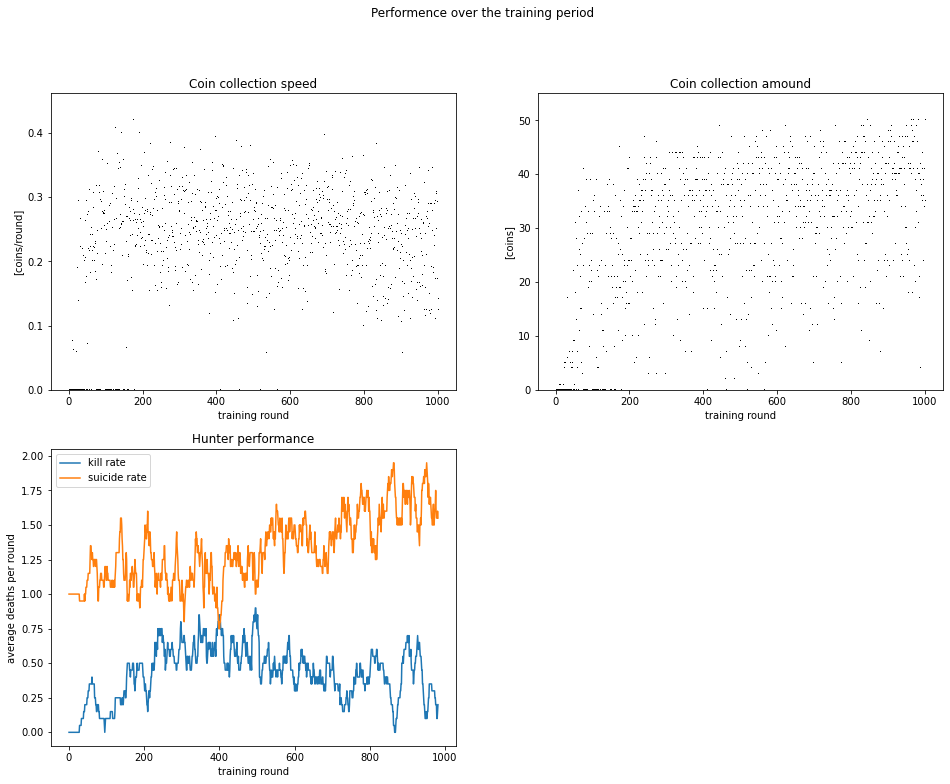

In [11]:
plt.figure(figsize = (16,12))
plt.suptitle("Performence over the training period")

plt.subplot(2, 2, 1)
speed = collected_coins / round_lengths
plt.plot(rounds, speed, ',k')
plt.ylim((0, 1.1*max(speed)))
plt.title("Coin collection speed")
plt.ylabel("[coins/round]")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")

plt.subplot(2, 2, 2)
plt.plot(rounds, collected_coins, ',k')
plt.ylim((0, 1.1*max(collected_coins)))
plt.title("Coin collection amound")
plt.ylabel("[coins]")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")

plt.subplot(2, 2, 3)
plt.plot(rounds[:-avg_length+1], kill_rate, label = "kill rate")
plt.plot(rounds[:-avg_length+1], suicide_rate, label = "suicide rate")
#plt.ylim((0, 1.1*max(np.amax(kill_rate), np.amax(suicide_rate))))
plt.title("Hunter performance")
plt.ylabel("average deaths per round")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")
plt.legend()

plt.show()



In [12]:
def analyze_action():
    Q_action = np.mean(allQs, axis = (1,2,3))
    labels  = ["action 0", "action 1", "action 2", "action 3", "WAIT", "BOMB"]

    plt.plot(np.arange(number_of_rounds) + 1, Q_action, label = labels)
    plt.title(f"Evolution of actions")
    plt.ylabel("Mean Q-value")
    plt.xlabel("training round")
    plt.legend()
    plt.show()

In [13]:
def analyze_state (state):
    state_index, f5, f6 = state
    Q_state = allQs[:, state_index, f5, f6]
    labels  = ["action 0", "action 1", "action 2", "action 3", "WAIT", "BOMB"]

    plt.plot(np.arange(training_rounds) + 1, Q_state, label = labels)
    plt.title(f"Evolution of state {state}")
    plt.ylabel("Q-value")
    plt.xlabel("training round")
    plt.legend()
    plt.show()

### Evolution of the Q-model

In [14]:
allQs = np.load("Qtrain.npy")

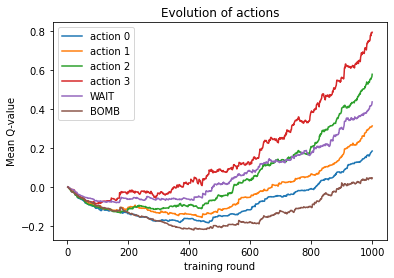

In [15]:
analyze_action()

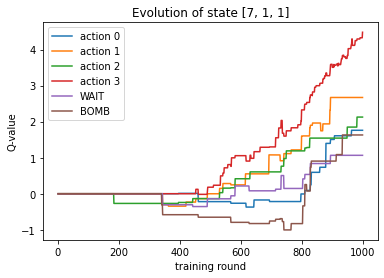

In [16]:
analyze_state([7, 1, 1])